In [1]:
# standard libraries
import datetime
import time

# 3rd party libraries
import seaborn as sb
import pandas as pd
import numpy as np

# local libraries
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.CovidDatasets import CDSDataset, JHUDataset

# vendor defaults
# set pandas display format for floats
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import matplotlib and related libraries
%matplotlib inline
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
# init dataset
# TODO describe contents of dataset module
Dataset = JHUDataset()
def model_state(country, state, interventions=None):
   
    ## Constants
    start_time = time.time()
    print(start_time)
    HOSPITALIZATION_RATE = .0727
    HOSPITALIZED_CASES_REQUIRING_ICU_CARE = .1397
    TOTAL_INFECTED_PERIOD = 12
    MODEL_INTERVAL = 4
    r0 = 3.2
    POP = Dataset.get_population_by_country_state(country, state)
    # Pack all of the assumptions and parameters into a dict that can be passed into the model
    MODEL_PARAMETERS = {
        # Pack the changeable model parameters
        'timeseries': Dataset.get_timeseries_by_country_state(country, state, MODEL_INTERVAL),
        'beds': Dataset.get_beds_by_country_state(country, state),
        'population': POP,
        #'projection_iterations': 25, # Number of iterations into the future to project
        'projection_iterations': 60, # Number of iterations into the future to project
        'r0': r0,
        'interventions': interventions,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        # Assumes that anyone who needs ICU care and doesn't get it dies
        'case_fatality_rate_hospitals_overwhelmed': HOSPITALIZATION_RATE * HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,
        'model_interval': 4, # In days
        'total_infected_period': 12, # In days
        'rolling_intervals_for_current_infected': int(round(TOTAL_INFECTED_PERIOD / MODEL_INTERVAL, 0)),
        'estimated_new_cases_per_death': 32,
        'estimated_new_cases_per_confirmed': 20,
        # added for seird model
        #'incubation_period': 5, # In days
        'use_harvard_init': use_harvard_init, #If True use the harvard model inputs for inital conditions and N (recreate their graph)

        
        'use_harvard_params': False, #If True use the harvard parameters directly, if not calculate off the above
        'fix_r0': False, #If True use the parameters that make R0 2.4, if not calculate off the above
        'hospitalization_rate': HOSPITALIZATION_RATE,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'total_infected_period': 12, # In days
        'duration_mild_infections': 6, # In days
        'hospital_time_recovery': 11, #Duration of hospitalization, In days
        'icu_time_death': 7, #Time from ICU admission to death, In days
        'case_fatality_rate': .0109341104294479,
        'beta': 0.5,
        'beta_hospitalized': 0.1,
        'beta_icu': 0.1,
        'presymptomatic_period': 3,
        'frac_infected_symptomatic': 1, # fraction of infected individuals who are symptomatic
        'exposed_from_infected': True,

        #'model': 'sir',
        'model': 'seir',
    }
    
    MODEL_PARAMETERS['exposed_infected_ratio'] = 1/MODEL_PARAMETERS['beta']

    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)

r0 = 2.4

INTERVENTIONS = [None, None, None, None]

In [5]:
#JHUDataset.get_timeseries_by_country_state('USA', 'TX', 1) #[['date','cases','deaths','recovered','active']]
#Dataset.get_beds_by_country_state('USA', 'NY')

In [6]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]

    x_dates = df['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
        
    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))

    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    #df_plt.set_xticklabels(labels=x_dates, rotation=45, ha='right')

    return(df_plt)

In [7]:
# Params with True
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 1000

# params with False
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 28995881.0

In [8]:
use_harvard_init = False #If True use the harvard model inputs for inital conditions and N (recreate their graph)
#use_harvard_init = True #If True use the harvard model inputs for inital conditions and N (recreate their graph)

1585774663.261153
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40873 entries, 0 to 40872
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      40873 non-null  int64         
 1   date       40873 non-null  datetime64[ns]
 2   country    40873 non-null  object        
 3   state      35917 non-null  object        
 4   county     31651 non-null  object        
 5   cases      40854 non-null  float64       
 6   deaths     40432 non-null  float64       
 7   recovered  40485 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 2.5+ MB
date           2020-11-25 00:00:00
total                     28995881
susceptible             1561733.35
exposed                       0.01
infected                      0.35
infected_a                    0.05
infected_b                    0.24
infected_c                    0.06
recovered              27133911.70
dead    

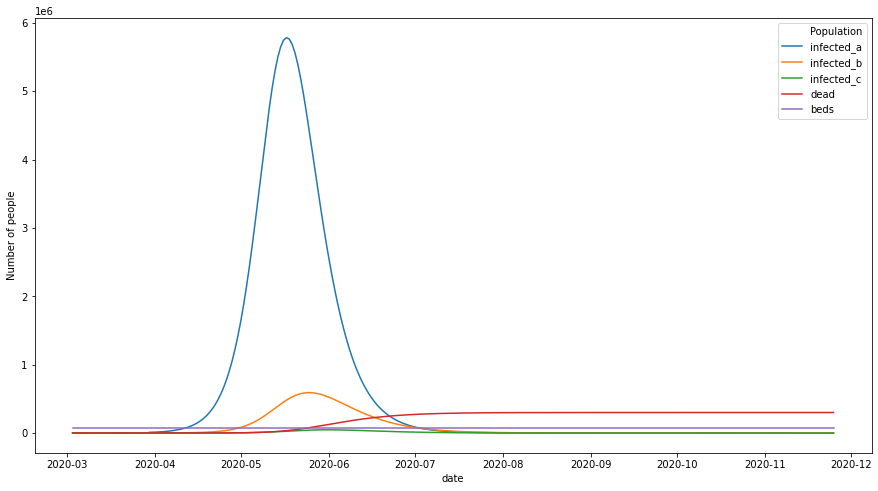

In [9]:
[initervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

print(initervention_df.iloc[-1])
#print(initervention_df.iloc[-20])

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(initervention_df, chart_cols)

1585774673.7854269
date           2020-11-25 00:00:00
total                     28995881
susceptible             1561733.35
exposed                       0.01
infected                      0.35
infected_a                    0.05
infected_b                    0.24
infected_c                    0.06
recovered              27133911.70
dead                     300235.59
beds                         66691
Name: 267, dtype: object


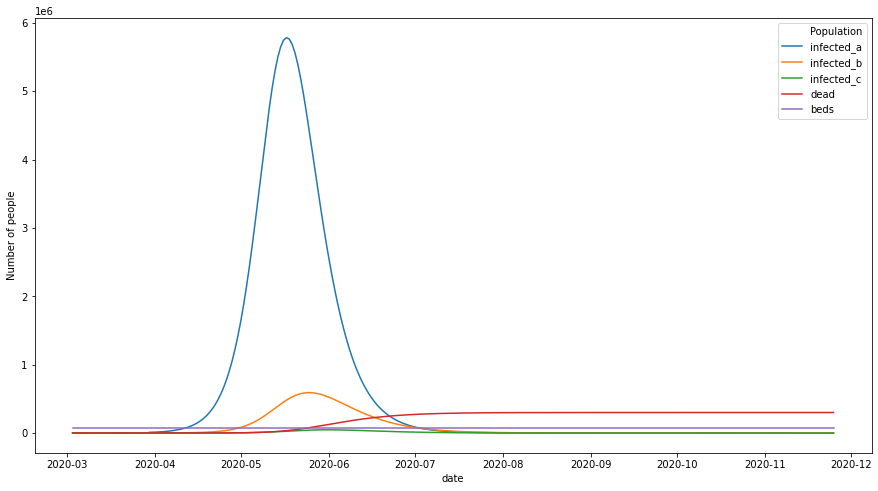

In [10]:
[initervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[3])

print(initervention_df.iloc[-1])
#print(initervention_df.iloc[-20])

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(initervention_df, chart_cols)

In [11]:
#initervention_df.describe()

In [12]:
print(initervention_df.loc[160:].head(50))

          date     total  susceptible  exposed  infected  infected_a  \
160 2020-08-10  28995881   1562239.07   202.58   4584.49     1068.50   
161 2020-08-11  28995881   1562193.57   183.75   4190.05      963.65   
162 2020-08-12  28995881   1562152.25   166.71   3829.80      869.40   
163 2020-08-13  28995881   1562114.71   151.29   3500.74      784.64   
164 2020-08-14  28995881   1562080.60   137.33   3200.15      708.40   
165 2020-08-15  28995881   1562049.60   124.70   2925.55      639.79   
166 2020-08-16  28995881   1562021.42   113.25   2674.65      578.02   
167 2020-08-17  28995881   1561995.79   102.89   2445.41      522.40   
168 2020-08-18  28995881   1561972.48    93.49   2235.93      472.28   
169 2020-08-19  28995881   1561951.28    84.97   2044.49      427.12   
170 2020-08-20  28995881   1561931.99    77.25   1869.54      386.40   
171 2020-08-21  28995881   1561914.43    70.24   1709.64      349.68   
172 2020-08-22  28995881   1561898.45    63.89   1563.48      31

1585774674.409873
date           2020-11-25 00:00:00
total                     28995881
susceptible             1561733.35
exposed                       0.01
infected                      0.35
infected_a                    0.05
infected_b                    0.24
infected_c                    0.06
recovered              27133911.70
dead                     300235.59
beds                         66691
Name: 267, dtype: object


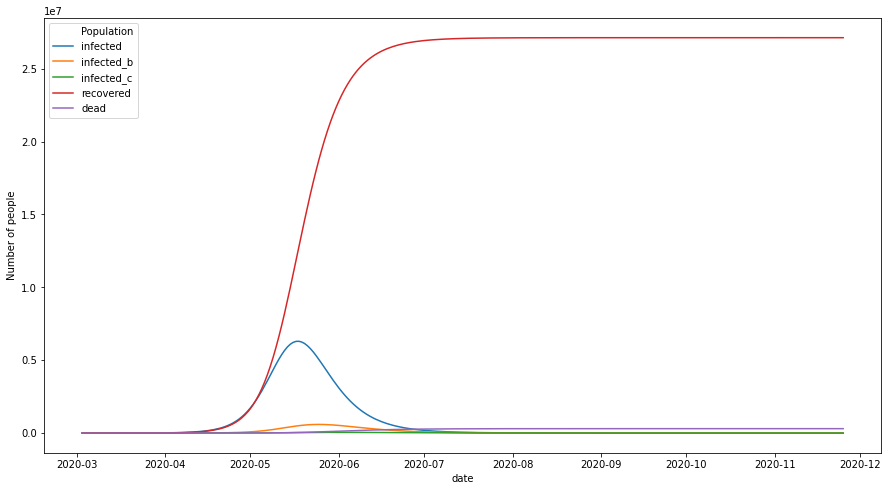

In [13]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[1])
    
print(initervention_df.iloc[-1])

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
#chart_cols = ["infected", "infected_b", "infected_c",  "dead"] #, "susceptible"]
plot_df(df, chart_cols)

[8.22704819e+07 1.64604627e+08 2.19472534e+07 1.95188728e+06
 8.51030506e+09 8.89823093e+07]
(365, 6)


(1, 28995881.0)

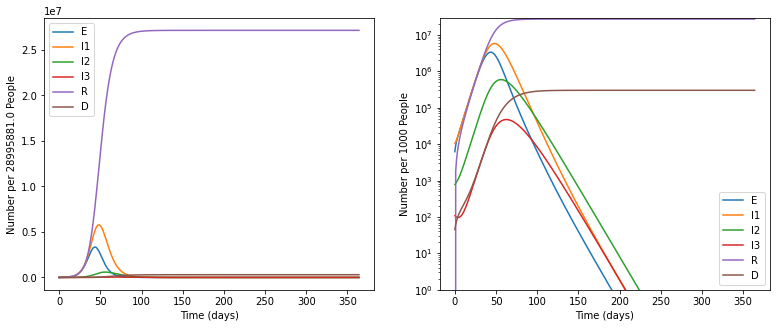

In [14]:
if use_harvard_init:
    tmax=365
    N = 1000
    tvec=np.arange(0,tmax,0.1)
else:
    # tmax = 80 * 4
    tmax = 365
    N =  28995881.00
    #N = 10000
    tvec=np.arange(0,tmax,1)
    
#print(np.array(N-np.sum(soln,axis=1,keepdims=True)))
#s = [N-np.sum(soln,axis=1,keepdims=True)]
#s = np.max(s,0)
soln_plt = np.hstack([soln])
#soln_plt = np.hstack(soln)

print(sum(soln_plt))
print(soln_plt.shape)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,soln_plt)
plt.xlabel("Time (days)")
plt.ylabel(f"Number per {str(N)} People")
#plt.legend(("S","E","I1","I2","I3","R","D"))
plt.legend(("E","I1","I2","I3","R","D"))

#plt.ylim([0,N])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,soln_plt)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
#plt.legend(("S","E","I1","I2","I3","R","D"))
plt.legend(("E","I1","I2","I3","R","D"))

plt.ylim([1,N])
#plt.tight_layout()